In [1]:
import os
import ot
import ot.plot
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import pandas as pd
import math
from scipy.spatial.distance import cdist

In [2]:
def Wass_dists(data, n):
    cpd_stat = np.zeros(len(data)// 1, )
    count = 0
    for i in range(0, len(data)-1, 1):
        if i<n or i>= len(data)- n:
            cpd_stat[count] = 0
        else:
            x, y = data[i-n:i], data[i: i+n]
            cpd_stat[count] = ot.emd2_1d(x, y)
        count += 1
    return cpd_stat  

def quick_transition_CPs(wass_dist, q, w):
    quantile = np.quantile(wass_dist, q)
    peaks, _ = find_peaks(wass_dist, height=quantile, width=w)
    
    return peaks

def torus_distance(p1, p2):
    # Unpack points
    x1, y1 = p1
    x2, y2 = p2
    # Calculate differences in x and y coordinates
    dx = abs(x1 - x2)
    dy = abs(y1 - y2)
    # Take into account toroidal wrapping
    dx = min(dx, 360 - dx)
    dy = min(dy, 360 - dy)
    # Calculate Euclidean distance -- by not taking square root, we will be using the W_2 distance and not the W_1 distance
    distance = dx**2 + dy**2
    return distance

def EMD(p1, p2):
    a = np.ones(len(p1))/len(p1)
    b = np.ones(len(p2))/len(p2)
    M = cdist(p1, p2, lambda u, v: torus_distance(u, v))
    return ot.emd2(a, b, M)

def get_infl(wass_dists, gradient, quantile):
    maxima_indices = []
    grad = []
    time = []
    for i in range(len(wass_dists)):
        if wass_dists[i] > quantile:
            grad.append(gradient[i])
            time.append(i)
        else:
            if len(grad) == 0:
                pass
            
            else:
                ind = min(time)
                maxima_indices.append(np.argmax(grad) + ind)
                maxima_indices.append(np.argmin(grad) + ind)

                #Plot the change points scaled by sliding window size

                grad = []
                time = []

    return maxima_indices

def construct_combined_states(pts, CPS, start, end):
    unshifted_states = {"metastable": [], "transition": []}
    all_state_cons = []
    for i in range(len(CPS)):
        if i!=0 and i < len(CPS)-1:
            curr_cp = CPS[i][0]
            next_cp = CPS[i+1][0]

            curr_label = CPS[i][1]
            next_label = CPS[i+1][1]
        elif i==0:
            curr_cp = start
            next_cp = CPS[i+1][0]

            curr_label = 'phi'
            next_label = CPS[i+1][1]
        else:
            curr_cp = CPS[i][0]
            next_cp = end

            curr_label = CPS[i][1]
            next_label = 'phi'
        
        unshifted_subseq = pts[curr_cp:next_cp]
        all_state_cons.append(unshifted_subseq)
        if curr_label == 'phi' and next_label == 'phi':
            unshifted_states["metastable"].append(unshifted_subseq)
        elif curr_label == 'phi' and next_label == 'enter_psi':
            unshifted_states["metastable"].append(unshifted_subseq)
        elif curr_label == 'exit_psi' and next_label == 'phi':
            unshifted_states["metastable"].append(unshifted_subseq)
        elif curr_label == 'exit_psi' and next_label == 'enter_psi':
            unshifted_states["metastable"].append(unshifted_subseq)

        else:
            unshifted_states["transition"].append(unshifted_subseq)

    return unshifted_states, all_state_cons

In [3]:
start = 0
end = 100000

data_shifted = np.loadtxt("data/ADP_2D.txt")
df = pd.read_csv('ADP_data/A_2D_1ps.dat', header=None, skipinitialspace=True, sep=' ', names=['phi', 'psi'])
points = np.array(df)[start:end]
pts = np.array(df)

In [4]:
psi = data_shifted[:,1]
phi = data_shifted[:,0]
wass_dists_phi = Wass_dists(phi[start:end], 10)
wass_dists_psi = Wass_dists(psi[start:end], 25)
CPS_phi = quick_transition_CPs(wass_dists_phi, 0.80, 1)

grad_psi = np.gradient(wass_dists_psi)
quantile_psi = np.quantile(wass_dists_psi, 0.75)

CPS_psi = get_infl(wass_dists_psi, grad_psi, quantile_psi)
CPS_psi = [i+start for i in CPS_psi]
CPS_phi = [i+start for i in CPS_phi]

Text(0.5, 1.0, 'Dihedral Angle Psi')

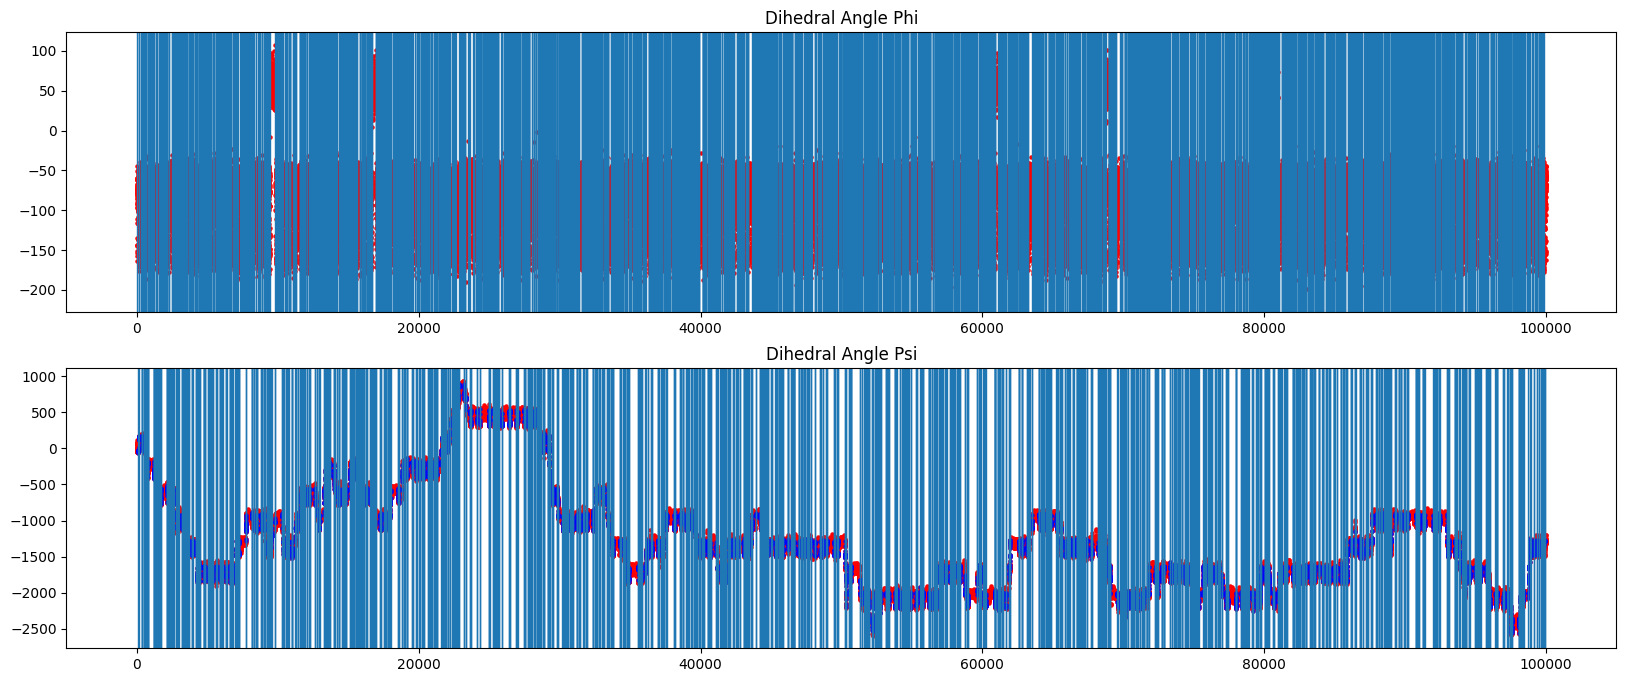

In [5]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(20,8))
ax1.scatter(np.arange(start, end), phi[start:end], c='r', s=5)
ax2.scatter(np.arange(start, end), psi[start:end], c='r', s=5)
for i in CPS_phi:
    ax1.axvline(i, -2000,500,linewidth=1)
    #ax2.axvline(i, -2000,500,linewidth=1, color='purple', linestyle='dashed')
for i in CPS_psi:
    ax2.axvline(i, -2000,500, linewidth=1)

for i in range(int(len(CPS_psi)/2)):
    ind1 = CPS_psi[2*i]
    ind2 = CPS_psi[2*i+1]
    ax2.scatter(np.arange(ind1, ind2, 1), psi[ind1:ind2], c='b', s=5, alpha=0.7)

ax1.set_title("Dihedral Angle Phi")
ax2.set_title("Dihedral Angle Psi")

In [6]:
# todo: take union of these change points?

labeled_phi = [(element, 'phi') for element in CPS_phi]
labeled_psi = []

for i in range(int(len(CPS_psi)/2)):
    labeled_psi.append((CPS_psi[2*i], 'enter_psi'))
    labeled_psi.append((CPS_psi[2*i+1], 'exit_psi'))

# Combining the labeled arrays
combined_array = labeled_phi + labeled_psi

sorted_array = sorted(combined_array, key=lambda x: x[0])

In [8]:
list_unshifted, all_of_unshifted_states = construct_combined_states(pts, sorted_array, start, end)

In [10]:
transition_regions = list_unshifted["transition"]
metastable_regions = list_unshifted["metastable"]

In [97]:
flat_regions = [i for i in metastable_regions if len(i) != 0]
all_regions = [i for i in all_of_unshifted_states if len(i) != 0]

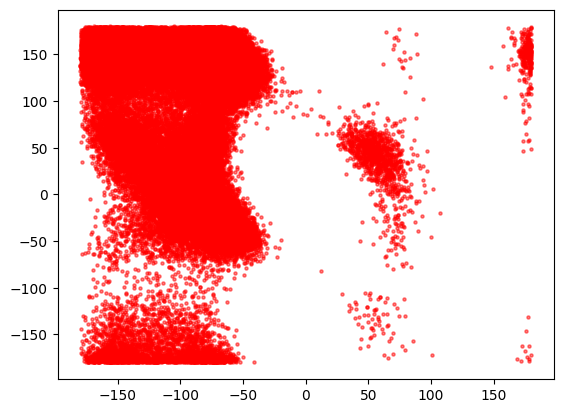

In [12]:
for i in all_regions:
    plt.scatter(i[:,0], i[:,1], s=5, c='r', alpha=0.5)

In [84]:
metastable_region = list_unshifted["metastable"]

dist_between_flat_regions = np.zeros((len(flat_regions),len(flat_regions)))

for i in tqdm(range(len(flat_regions))):
    for j in range(len(flat_regions)):
        if i == j:
            dist_between_flat_regions[i][j] = 0
        else:
            dist_between_flat_regions[i][j] = EMD(flat_regions[i], flat_regions[j])

print(dist_between_flat_regions.shape)

100%|██████████| 3955/3955 [11:42:22<00:00, 10.66s/it]   

(3955, 3955)


In [85]:
pairwise_dist_between_all_regions = np.zeros((len(all_regions),len(all_regions)))

for i in tqdm(range(len(all_regions))):
    for j in range(len(all_regions)):
        if i == j:
            pairwise_dist_between_all_regions[i][j] = 0
        else:
            pairwise_dist_between_all_regions[i][j] = EMD(all_regions[i], all_regions[j])

print(pairwise_dist_between_all_regions.shape)

100%|██████████| 5204/5204 [23:35:02<00:00, 16.31s/it]    

(5204, 5204)


In [14]:
from sklearn.cluster import KMeans, SpectralClustering

def Gaussian_kernel(distances):
    sigma = 0.75*np.mean(distances[distances>0])
    return np.exp(-(distances**2 / (sigma**2)))

def get_clusters_KM(X,k):
    Kmeans = KMeans(max_iter=1000, n_clusters=k, random_state=5)
    Kmeans.fit(X)
    return Kmeans.labels_

def getDistCut(distList,distPercent):
    return max(distList) * distPercent / 100

def compute_nearest_neighbor_distances(distances, ln_N):
    N = distances.shape[0]
    ln_nth_nearest_distances = np.zeros(N)
    
    # Sort distances for each point
    sorted_distances = np.sort(distances, axis=1)
    
    for i in range(N):
        ln_nth_nearest_distances[i] = sorted_distances[i, ln_N]
    
    return ln_nth_nearest_distances

def set_kernel_density_cutoff(ln_nth_nearest_distances):
    cutoff = np.mean(ln_nth_nearest_distances)
    print(cutoff)
    return cutoff
 
def getRho(n,distMatrix,distCut):
    rho = np.zeros(n,dtype=float)
    for i in range(n-1):
        for j in range(i+1,n):
            rho[i] = rho[i] + np.exp(-(distMatrix[i, j] / distCut) ** 2)
            rho[j] = rho[j] + np.exp(-(distMatrix[i, j] / distCut) ** 2)
    return rho

def DPCA(n,distMatrix,rho,blockNum):
    rhoOrdIndex = np.flipud(np.argsort(rho))
    delta = np.zeros(n,dtype=float)
    leader = np.ones(n,dtype=int) * int(-1)
    maxdist = 0
    for ele in range(n):
        if distMatrix[rhoOrdIndex[0],ele] > maxdist:
            maxdist = distMatrix[rhoOrdIndex[0],ele]
    delta[rhoOrdIndex[0]] = maxdist
    for i in range(1,n):
        mindist = np.inf
        minindex = -1
        for j in range(i):
            if distMatrix[rhoOrdIndex[i],rhoOrdIndex[j]] < mindist:
                mindist = distMatrix[rhoOrdIndex[i],rhoOrdIndex[j]]
                minindex = rhoOrdIndex[j]
        delta[rhoOrdIndex[i]] = mindist
        leader[rhoOrdIndex[i]] = minindex
    gamma = delta * rho
    gammaOrdIdx = np.flipud(np.argsort(gamma))
    clusterIdx = np.ones(n,dtype=int) * (-1)
    for k in range(blockNum):
        clusterIdx[gammaOrdIdx[k]] = k
    for i in range(n):
        if clusterIdx[rhoOrdIndex[i]] == -1:
            clusterIdx[rhoOrdIndex[i]] = clusterIdx[leader[rhoOrdIndex[i]]]
    clusterSet = OrderedDict()
    for k in range(blockNum):
        clusterSet[k] = []
    for i in range(n):
        clusterSet[clusterIdx[i]].append(i)
    return clusterSet

def select_dc(dists):    
    N = np.shape(dists)[0]
    tt = np.reshape(dists,N*N)
    percent = 2.0
    position = int(N * (N - 1) * percent / 100)
    dc = np.sort(tt)[position  + N]
    print(dc)
    return dc
    
def get_density(dists,dc,method=None):
    N = np.shape(dists)[0]
    rho = np.zeros(N)
    
    for i in range(N):
        if method == None:
            rho[i]  = np.where(dists[i,:]<dc)[0].shape[0]-1
        else:
            rho[i] = np.sum(np.exp(-(dists[i,:]/dc)**2))-1
    return rho

def get_deltas(dists,rho):
    N = np.shape(dists)[0]
    deltas = np.zeros(N)
    nearest_neighbor = np.zeros(N)

    index_rho = np.argsort(-rho)
    for i,index in enumerate(index_rho):

        if i==0:
            continue
  
        index_higher_rho = index_rho[:i]
 
        deltas[index] = np.min(dists[index,index_higher_rho])
        
        index_nn = np.argmin(dists[index,index_higher_rho])
        nearest_neighbor[index] = index_higher_rho[index_nn].astype(int)
    
    deltas[index_rho[0]] = np.max(deltas)   
    return deltas,nearest_neighbor
  
def find_centers_K(rho,deltas,K):
    rho_delta = rho*deltas
    centers = np.argsort(-rho_delta)
    return centers[:K]

def cluster_PD(rho,centers,nearest_neiber):
    K = np.shape(centers)[0]
    if K == 0:
        print("can not find centers")
        return
    
    N = np.shape(rho)[0]
    labs = -1*np.ones(N).astype(int)
    
    for i, center in enumerate(centers):
        labs[center] = i
    index_rho = np.argsort(-rho)
    for i, index in enumerate(index_rho):

        if labs[index] == -1:
            labs[index] = labs[int(nearest_neiber[index])]
    return labs
        
def draw_decision(states, rho,deltas,name="1.jpg"):       
    plt.cla()
    for i in range(np.shape(states)[0]):
        plt.scatter(rho[i],deltas[i],s=16.,color=(0,0,0))
        plt.annotate(str(i), xy = (rho[i], deltas[i]),xytext = (rho[i], deltas[i]))
        plt.xlabel("rho")
        plt.ylabel("deltas")
    plt.show()

# Implementing barycentric clustering

In [93]:
# Construct barycenter for each state
def get_ref_dist(labels, target, states, n_samples, reg):
    meta_state = [states[i] for i in range(len(labels)) if labels[i] == target]
    As = [ot.unif(len(i)) for i in meta_state]
    XB_init = np.random.randn(n_samples, 2)
    weights = np.ones(len(meta_state))/len(meta_state)

    reg = reg  # Entropic Regularization
    numItermax = 50  # Maximum number of iterations for the Barycenter algorithm
    numInnerItermax = 50  # Maximum number of sinkhorn iterations
    n_samples = n_samples
    

    XB = ot.bregman.free_support_sinkhorn_barycenter(
            measures_locations=meta_state,
            measures_weights=As,
            weights=weights,
            X_init=XB_init,
            reg=reg,
            numItermax=numItermax,
            numInnerItermax=numInnerItermax
        )

    for state in meta_state:
        plt.scatter(state[:,0], state[:,1], c='r', s=5, alpha=0.5)

    plt.scatter(XB[:, 0], XB[:, 1], color='steelblue', s=5)
    plt.xlim(-180,180)
    plt.ylim(-180,180)

    plt.show()

    return XB

# Construct barycenter for each state in slow transitioning angle
def get_trans_dist(X1, X2, n_samples, reg):
    reg = 100  # Entropic Regularization
    numItermax = 20  # Maximum number of iterations for the Barycenter algorithm
    numInnerItermax = 50  # Maximum number of sinkhorn iterations
    n_samples = 200
    weights = [1/2,1/2]

    a1 = ot.unif(len(X1))
    a2 = ot.unif(len(X2))
    XB_init = np.random.randn(n_samples, 2)

    XB = ot.bregman.free_support_sinkhorn_barycenter(
            measures_locations=[X1, X2],
            measures_weights=[a1, a2],
            weights=weights,
            X_init=XB_init,
            reg=reg,
            numItermax=numItermax,
            numInnerItermax=numInnerItermax
        )
    plt.scatter(X1[:, 0], X1[:, 1], color='r', s=5)
    plt.scatter(X2[:, 0], X2[:, 1], color='b', s=5)
    plt.scatter(XB[:, 0], XB[:, 1], color='steelblue', s=5)
    plt.xlim(-180,180)
    plt.ylim(-180,180)

    plt.show()

    return XB

In [101]:
dists = dist_between_flat_regions
alternate_dc = select_dc(dists)
file_name = "DPCA1"

rho = get_density(dists,259,method="Gaussian")
deltas, nearest_neighbor= get_deltas(dists,rho)
draw_decision(dists, rho,deltas,name=file_name+"_decision.jpg")

centers = find_centers_K(rho, deltas, 5)
print("cluster-centers",centers)
labs = cluster_PD(rho,centers,nearest_neighbor)

new_traj = []
for i in range(len(labs)):
    ar = np.full(len(all_regions[i]), labs[i])
    new_traj.append(ar)

traj = np.concatenate(new_traj)

unique, counts = np.unique(traj, return_counts=True)

214.62506247402573


0.32727
0.11742
0.00189
0.29783
0.0198


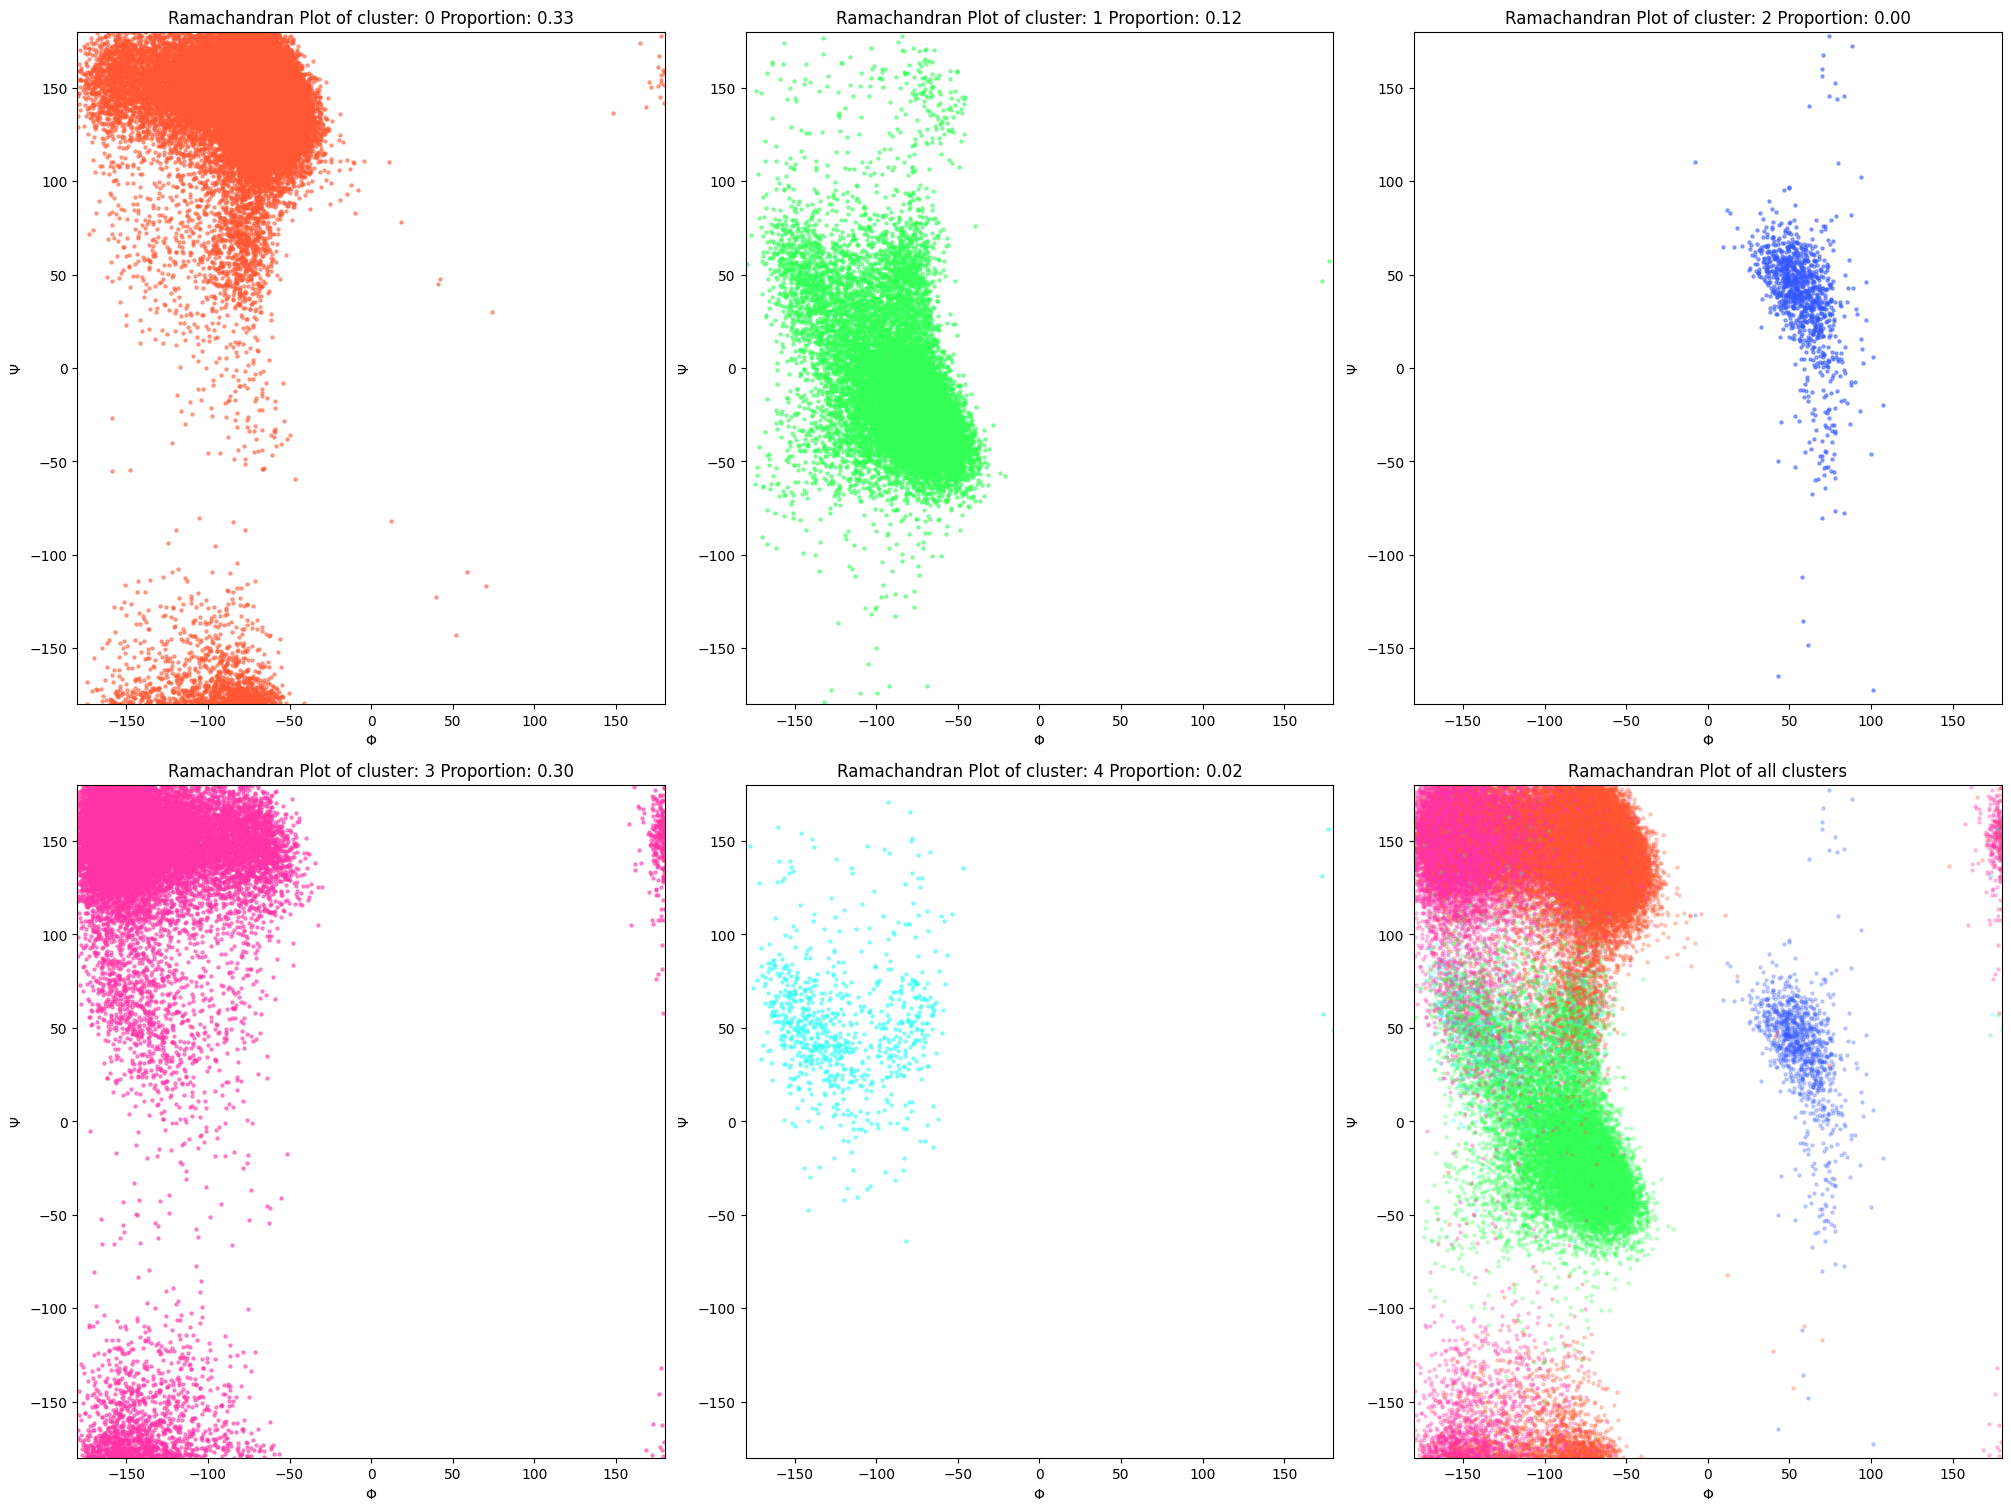

In [98]:
colors = [
    "#FF5733",  # Red-Orange
    "#33FF57",  # Lime Green
    "#3357FF",  # Blue
    "#FF33A6",  # Pink
    "#33FFF5",  # Cyan
    "#FFBD33",  # Orange
    "#8D33FF",  # Purple
    "#FF5733",  # Red
    "#33FFBD",  # Mint
    "#FFFF33"   # Yellow
]
states = flat_regions

n_clusters = 5
rows = int(n_clusters/3) + 1

fig, ax = plt.subplots(rows, 3, figsize=(20, 15), layout="constrained")
counter = 0
for i in range(rows):
    for j in range(3):
        if counter==n_clusters:
            for k in range(len(labs)):
                ax[i, j].scatter(states[k][:,0],states[k][:,1], s=5, c=colors[labs[k]],alpha=0.25)
            ax[i, j].set_title("Ramachandran Plot of all clusters")
        else:
            for k in range(len(labs)):
                if labs[k] ==counter:
                    ax[i, j].scatter(states[k][:,0],states[k][:,1], s=5, c=colors[labs[k]],alpha=0.5)
            valz = counts[counter]/100000
            print(valz)
            str1_lst = ['Ramachandran Plot of cluster: ', counter, ' Proportion: ', f"{valz:.2f}" ]
            str1 = ''.join(map(str,str1_lst))
            ax[i, j].set_title(str1)
        counter+=1
        ax[i, j].set_xlabel("$\Phi$")
        ax[i, j].set_ylabel("$\Psi$")
        ax[i, j].set_xlim(-180,180)
        ax[i, j].set_ylim(-180,180)


In [39]:
for i in range(len(labs)):
    if labs[i] == 4:
        labs[i] = 0

/Users/joshhuang/HILDA/HILDA_env/lib/python3.9/site-packages/ot/bregman/_sinkhorn.py:531: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
/Users/joshhuang/HILDA/HILDA_env/lib/python3.9/site-packages/ot/bregman/_sinkhorn.py:499: RuntimeWarning: divide by zero encountered in divide
  u = 1. / nx.dot(Kp, v)
/Users/joshhuang/HILDA/HILDA_env/lib/python3.9/site-packages/ot/bregman/_sinkhorn.py:506: UserWarning: Warning: numerical errors at iteration 0
  warnings.warn('Warning: numerical errors at iteration %d' % ii)


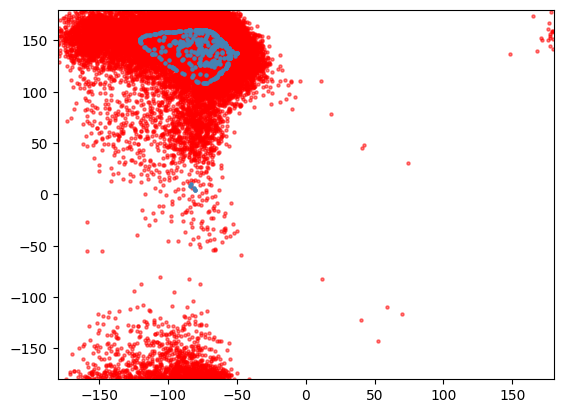

/Users/joshhuang/HILDA/HILDA_env/lib/python3.9/site-packages/ot/bregman/_sinkhorn.py:498: RuntimeWarning: divide by zero encountered in divide
  v = b / KtransposeU


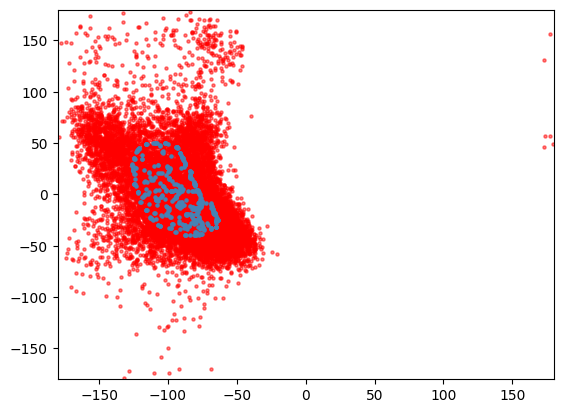

/Users/joshhuang/HILDA/HILDA_env/lib/python3.9/site-packages/ot/bregman/_sinkhorn.py:498: RuntimeWarning: overflow encountered in divide
  v = b / KtransposeU
/Users/joshhuang/HILDA/HILDA_env/lib/python3.9/site-packages/ot/bregman/_sinkhorn.py:506: UserWarning: Warning: numerical errors at iteration 47
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/Users/joshhuang/HILDA/HILDA_env/lib/python3.9/site-packages/ot/bregman/_sinkhorn.py:506: UserWarning: Warning: numerical errors at iteration 38
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/Users/joshhuang/HILDA/HILDA_env/lib/python3.9/site-packages/ot/bregman/_sinkhorn.py:506: UserWarning: Warning: numerical errors at iteration 37
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/Users/joshhuang/HILDA/HILDA_env/lib/python3.9/site-packages/ot/bregman/_sinkhorn.py:506: UserWarning: Warning: numerical errors at iteration 49
  warnings.warn('Warning: numerical errors at iteration %d' % i

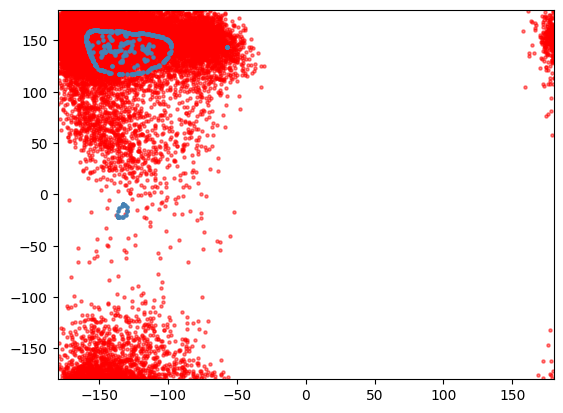

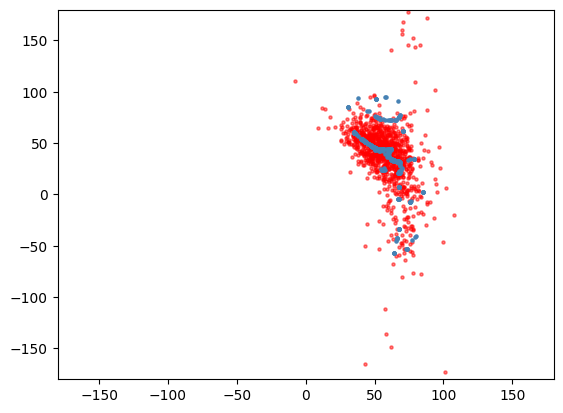

In [40]:
Bar0 = get_ref_dist(labs, 0, flat_regions, 500, 100)
Bar1 = get_ref_dist(labs, 1, flat_regions, 500, 100)
Bar2 = get_ref_dist(labs, 2, flat_regions, 500, 100)
Bar3 = get_ref_dist(labs, 3, flat_regions, 500, 100)

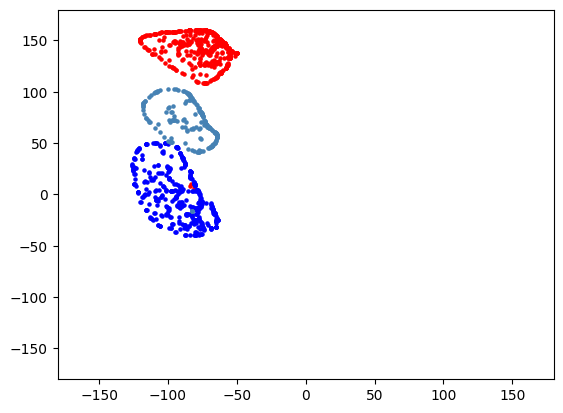

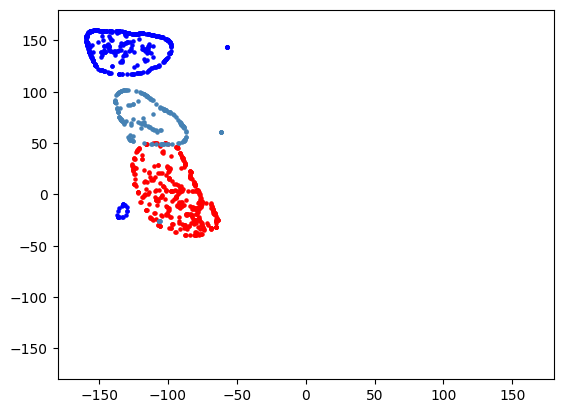

In [41]:
Trans_01 = get_trans_dist(Bar0, Bar1, 500, 100)
Trans_12 = get_trans_dist(Bar1, Bar2, 500, 100)

Text(0, 0.5, '$\\Psi$')

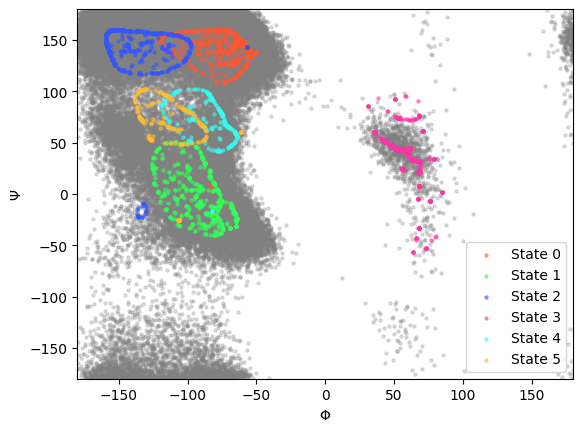

In [42]:
colors = [
    "#FF5733",  # Red-Orange
    "#33FF57",  # Lime Green
    "#3357FF",  # Blue
    "#FF33A6",  # Pink
    "#33FFF5",  # Cyan
    "#FFBD33",  # Orange
    "#8D33FF",  # Purple
    "#FF5733",  # Red
    "#33FFBD",  # Mint
    "#FFFF33"   # Yellow
]

plt.scatter(points[:,0], points[:,1], s=5, c='grey' ,alpha=0.25)

plt.scatter(Bar0[:,0], Bar0[:,1], s=5, c=colors[0] ,alpha=0.5, label='State 0')
plt.scatter(Bar1[:,0], Bar1[:,1], s=5, c=colors[1] ,alpha=0.5, label='State 1')
plt.scatter(Bar2[:,0], Bar2[:,1], s=5, c=colors[2] ,alpha=0.5, label='State 2')
plt.scatter(Bar3[:,0], Bar3[:,1], s=5, c=colors[3] ,alpha=0.5, label='State 3')
plt.scatter(Trans_01[:,0], Trans_01[:,1], s=5, c=colors[4] ,alpha=0.5, label='State 4')
plt.scatter(Trans_12[:,0], Trans_12[:,1], s=5, c=colors[5] ,alpha=0.5, label='State 5')


plt.xlim(-180,180)
plt.ylim(-180,180)
plt.legend()
plt.xlabel("$\Phi$")
plt.ylabel("$\Psi$")

In [43]:
barys = [Bar0, Bar1, Bar2, Bar3, Trans_01, Trans_12]

In [44]:
#The label for each point cloud will be it closest barycenter in Toroidal distance
def Barycentric_labelling(states, barycenters):
    labels = np.zeros(len(states))
    for i in tqdm(range(len(states))):
        labels[i] = np.argmin([EMD(states[i], barycenters[j]) for j in range(len(barycenters))])
    return labels

In [45]:
labels = Barycentric_labelling(all_regions, barys)

100%|██████████| 5204/5204 [16:52<00:00,  5.14it/s]  


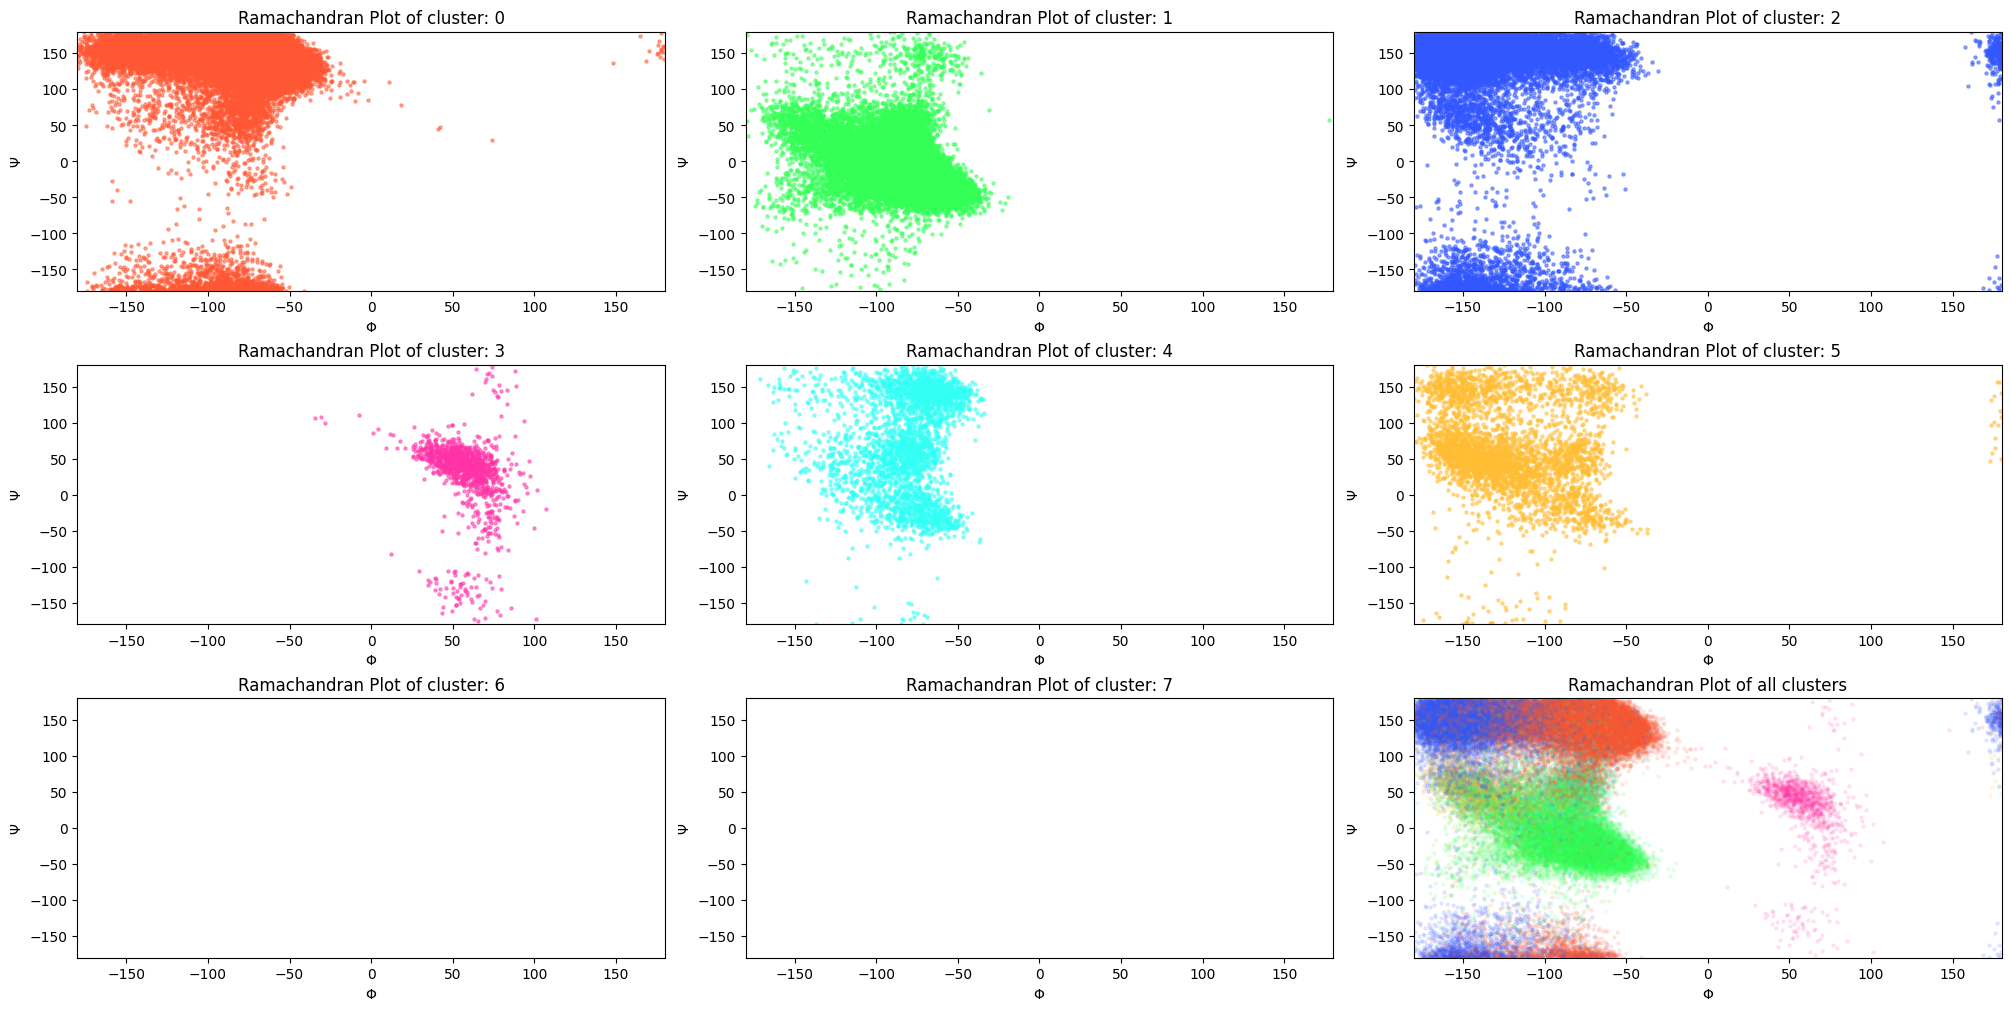

In [75]:
colors = [
    "#FF5733",  # Red-Orange
    "#33FF57",  # Lime Green
    "#3357FF",  # Blue
    "#FF33A6",  # Pink
    "#33FFF5",  # Cyan
    "#FFBD33",  # Orange
    "#8D33FF",  # Purple
    "#FF5733",  # Red
    "#33FFBD",  # Mint
    "#FFFF33"   # Yellow
]

fig, ax = plt.subplots(3, 3, figsize=(20, 10), layout="constrained")
counter = 0
for i in range(3):
    for j in range(3):
        if counter==8:
            for k in range(len(labels)):
                ax[i, j].scatter(all_regions[k][:,0],all_regions[k][:,1], s=5, c=colors[int(labels[k])],alpha=0.1)
            ax[i, j].set_title("Ramachandran Plot of all clusters")
        else:
            for k in range(len(labels)):
                if labels[k] ==counter:
                    ax[i, j].scatter(all_regions[k][:,0],all_regions[k][:,1], s=5, c=colors[int(labels[k])],alpha=0.5)
            str1_lst = ['Ramachandran Plot of cluster: ', counter]
            str1 = ''.join(map(str,str1_lst))
            ax[i, j].set_title(str1)
        counter+=1
        ax[i, j].set_xlabel("$\Phi$")
        ax[i, j].set_ylabel("$\Psi$")
        ax[i, j].set_xlim(-180,180)
        ax[i, j].set_ylim(-180,180)


In [76]:
Trajectory=pd.DataFrame(labels)
Trajectory.to_csv('data/ClusterTrajectory_total=100000_Barycenters.txt', header=False, index=False);